# imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
from wordcloud import WordCloud
%matplotlib inline

pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Load dataset (Task 1)

In [2]:
fn = "metadata.csv"
print("Loading:", fn)
df = pd.read_csv(fn, engine="python", on_bad_lines="skip")
print("Loaded shape:", df.shape)
display(df.head(3))

Loading: metadata.csv
Loaded shape: (19273, 19)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636.0,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967.0,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972.0,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


# Data structure & missing values

In [3]:
print("Columns:", len(df.columns))
display(df.dtypes)
print("\nMissing values (top columns):")
display(df.isnull().sum().sort_values(ascending=False).head(30))
print("\nBasic numeric stats:")
display(df.describe(include=[np.number]))

Columns: 19


,0
cord_uid,object
sha,object
source_x,object
title,object
doi,object
pmcid,object
pubmed_id,float64
license,object
abstract,object
publish_time,object



Missing values (top columns):


,0
s2_id,19273
mag_id,19273
who_covidence_id,19271
arxiv_id,19271
pmc_json_files,4252
abstract,3587
pdf_json_files,2190
sha,2188
authors,955
journal,380



Basic numeric stats:


,pubmed_id,mag_id,s2_id
count,1.927200e+04,0.0,0.0
mean,2.777018e+07,NaN,NaN
std,9.182370e+06,NaN,NaN
min,2.142000e+03,NaN,NaN
25%,2.358299e+07,NaN,NaN
50%,3.217130e+07,NaN,NaN
75%,3.457269e+07,NaN,NaN
max,3.512069e+07,NaN,NaN


# Inspect important columns

In [4]:
for c in ['cord_uid','title','abstract','publish_time','journal','source_x']:
    if c in df.columns:
        print(f"\n--- Column: {c} ---")
        print("Non-null count:", df[c].notnull().sum())
        display(df[c].sample(3))


--- Column: cord_uid ---
Non-null count: 19273


,cord_uid
8866,09gp99xs
2359,ik4ps0qn
7237,ym31dv3h



--- Column: title ---
Non-null count: 19272


,title
11721,Neural Decoding of EEG Signals with Machine Le...
15134,French researchers at boiling point
6249,Pharmacoepidemiology Research-Real-World Evide...



--- Column: abstract ---
Non-null count: 15686


,abstract
17075,NaN
9322,NaN
11872,Nasal polyps (NPs) are benign inflammatory mas...



--- Column: publish_time ---
Non-null count: 19272


,publish_time
6713,2018-09-27
12502,2017-05-27
4777,2021-07-28



--- Column: journal ---
Non-null count: 18893


,journal
16175,Child Adolesc Psychiatry Ment Health
155,J R Soc Interface
13200,Rev Esp Quimioter



--- Column: source_x ---
Non-null count: 19273


,source_x
15460,PMC
9532,PMC
4066,PMC


# Data cleaning strategy

In [5]:
if 'publish_time' in df.columns:
    df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
    df['year'] = df['publish_time'].dt.year

df['title'] = df['title'].astype(str).replace('nan', np.nan)
df['abstract'] = df['abstract'].astype(str).replace('nan', np.nan)

df['abstract_word_count'] = df['abstract'].fillna("").apply(lambda s: len(re.findall(r"\w+", s)))
df['title_word_count'] = df['title'].fillna("").apply(lambda s: len(re.findall(r"\w+", s)))

missing_frac = df.isnull().mean().sort_values(ascending=False)
display(missing_frac.head(30))

clean_df = df.dropna(subset=['title','abstract','publish_time'], how='all').copy()
print("Cleaned shape:", clean_df.shape)

,0
s2_id,1.000000
mag_id,1.000000
who_covidence_id,0.999896
arxiv_id,0.999896
pmc_json_files,0.220620
abstract,0.186063
pdf_json_files,0.113630
sha,0.113527
authors,0.049551
year,0.049032


Cleaned shape: (19273, 22)


# Fill or drop other missing values

In [6]:
if 'cord_uid' in clean_df.columns:
    clean_df = clean_df[clean_df['cord_uid'].notnull()]
print("After cord_uid filter:", clean_df.shape)

After cord_uid filter: (19273, 22)


# Basic analysis: papers by year, top journals, top sources

In [7]:
pubs_by_year = clean_df['year'].value_counts().sort_index()
display(pubs_by_year.head(20))


if 'journal' in clean_df.columns:
    top_journals = clean_df['journal'].value_counts().head(20)
    display(top_journals)

if 'source_x' in clean_df.columns:
    top_sources = clean_df['source_x'].value_counts().head(20)
    display(top_sources)

,count
year,
1964.0,1
1969.0,2
1970.0,3
1971.0,3
1972.0,4
1973.0,3
1974.0,7
1975.0,11
1976.0,7


,count
journal,
PLoS One,971
Sci Rep,579
Lancet,282
Int J Environ Res Public Health,256
Viruses,204
Intensive Care Med,201
Int J Mol Sci,181
BMC Infect Dis,181
Arch Virol,172


,count
source_x,
PMC,19272
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381288/,1


# Word frequency in titles

In [8]:
stopwords = set([
    "the","and","of","in","to","a","for","on","with","by","from","is","are","an","sars","cov","covid","covid19"
])
def tokenize_title(s):
    tokens = re.findall(r"\w+", s.lower())
    return [t for t in tokens if t not in stopwords and len(t) > 2]

all_tokens = []
for t in clean_df['title'].dropna().astype(str):
    all_tokens.extend(tokenize_title(t))
counter = Counter(all_tokens)
top_words = counter.most_common(40)
display(top_words[:20])

[('virus', 1843),
 ('study', 1309),
 ('patients', 1050),
 ('health', 1033),
 ('influenza', 978),
 ('infection', 934),
 ('analysis', 931),
 ('based', 837),
 ('human', 836),
 ('disease', 833),
 ('cell', 793),
 ('respiratory', 762),
 ('review', 711),
 ('cells', 638),
 ('clinical', 631),
 ('acute', 630),
 ('care', 619),
 ('using', 602),
 ('protein', 587),
 ('viral', 561)]

# Visualizations

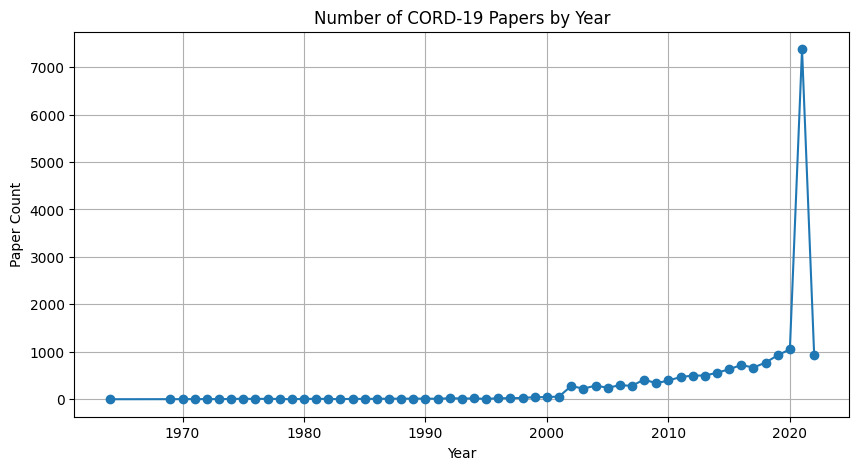

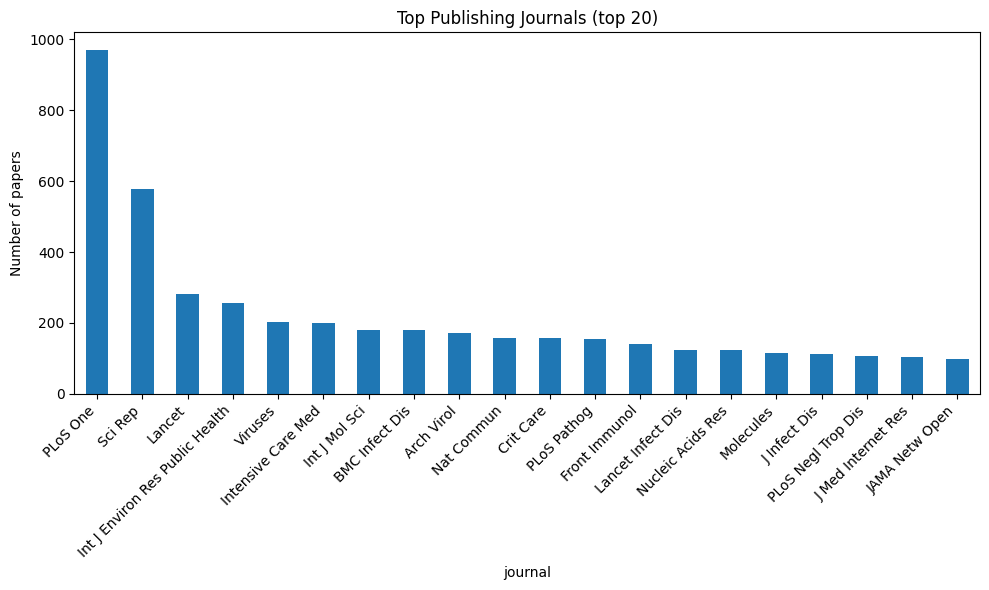

In [9]:
plt.figure(figsize=(10,5))
pubs_by_year.plot(kind='line', marker='o')
plt.title("Number of CORD-19 Papers by Year")
plt.xlabel("Year")
plt.ylabel("Paper Count")
plt.grid(True)
plt.show()

if 'journal' in clean_df.columns and not top_journals.empty:
    plt.figure(figsize=(10,6))
    top_journals.plot(kind='bar')
    plt.title("Top Publishing Journals (top 20)")
    plt.ylabel("Number of papers")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

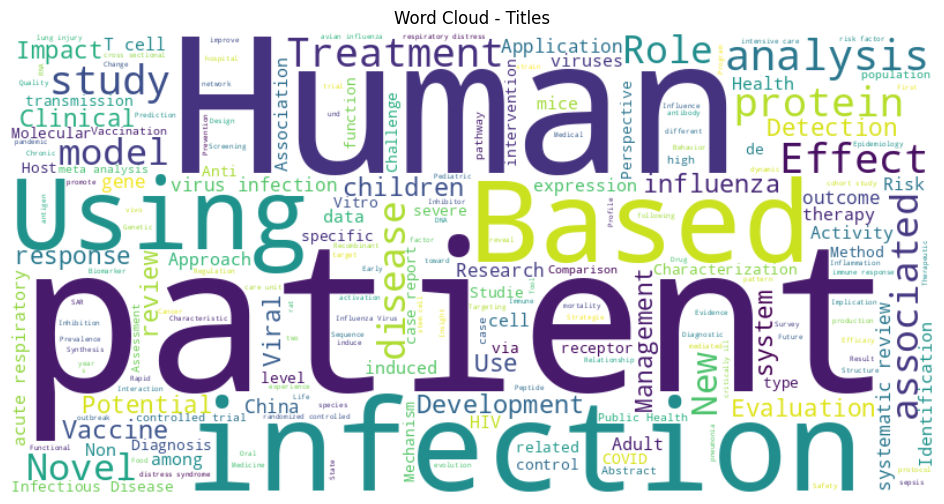

In [10]:
wc_text = " ".join(clean_df['title'].dropna().astype(str).values)
if len(wc_text) > 0:
    wc = WordCloud(width=800, height=400, background_color="white").generate(wc_text)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud - Titles")
    plt.show()

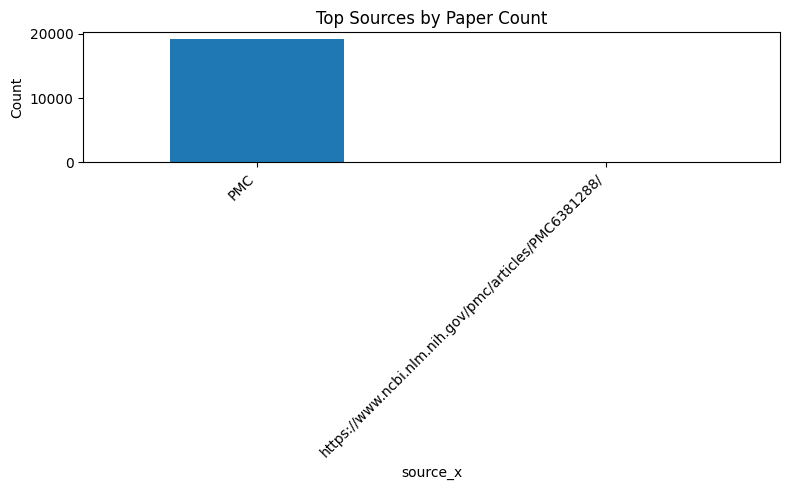

In [11]:
# Distribution of paper counts by source
if 'source_x' in clean_df.columns:
    plt.figure(figsize=(8,5))
    clean_df['source_x'].value_counts().head(10).plot(kind='bar')
    plt.title("Top Sources by Paper Count")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [12]:
# Save a cleaned CSV for Streamlit app
clean_fn = "metadata_cleaned.csv"
clean_df.to_csv(clean_fn, index=False)
print("Saved cleaned metadata to", clean_fn)

Saved cleaned metadata to metadata_cleaned.csv
